In [1]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import commot as ct

## **Load data**

In [2]:
adata = sq.datasets.slideseqv2()

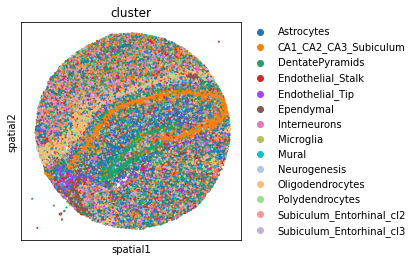

In [3]:
sc.pl.spatial(adata, color="cluster", spot_size=50)

In [11]:
adata.var_names

Index(['1010001B22Rik', '1110002J07Rik', '1110017D15Rik', '1190002F15Rik',
       '1300017J02Rik', '1500012K07Rik', '1500015O10Rik', '1500017E21Rik',
       '1600002K03Rik', '1700001C02Rik',
       ...
       'Zmym5', 'Zmym6', 'Zmynd10', 'Znhit6', 'Znrf3', 'Zscan10', 'Zswim3',
       'Zswim5', 'Zswim6', 'Zwilch'],
      dtype='object', length=4000)

## **Spot-spot communication network**

In [12]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse')
print(df_cellchat.shape)

(1209, 4)


In [5]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata, min_cell_pct=0.0)
print(df_cellchat_filtered.shape)

(55, 4)


In [6]:
ct.tl.spatial_communication(adata,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=200, heteromeric=True, pathway_sum=True)

In [7]:
adata.write('./data/adata.h5ad')

## **Communication directions**

In [8]:
adata = sc.read_h5ad("./data/adata.h5ad")

In [9]:
# rank the pathways by activity
def rank_signaling_activity(
    adata,
    database_name = None
):
    df_ligrec = adata.uns['commot-%s-info' % database_name]['df_ligrec']
    pathways = list(set(list(df_ligrec.iloc[:,2])))
    lr_pair_names = []
    for i in range(df_ligrec.shape[0]):
        lr_pair_names.append('%s-%s' % (df_ligrec.iloc[i,0], df_ligrec.iloc[i,1]))
    act_pathway = np.zeros([len(pathways)], float)
    act_lrpairs = np.zeros([len(lr_pair_names)], float)
    for i in range(len(act_pathway)):
        act_pathway[i] = np.sum(adata.obsm['commot-%s-sum-receiver' % database_name]['r-%s' % pathways[i]].values)
    for i in range(len(act_lrpairs)):
        act_lrpairs[i] = np.sum(adata.obsm['commot-%s-sum-receiver' % database_name]['r-%s' % lr_pair_names[i]].values)
    idx_pathway = np.argsort(-act_pathway)
    idx_lrpairs = np.argsort(-act_lrpairs)
    pathways = np.array(pathways, str)
    lr_pair_names = np.array(lr_pair_names, str)
    
    return pathways[idx_pathway], lr_pair_names[idx_lrpairs]

In [10]:
ranked_pathway, ranked_lrpair = rank_signaling_activity(adata, database_name='cellchat')

In [11]:
ranked_pathway

array(['CX3C', 'NRG', 'SEMATOSTATIN', 'EGF', 'IGF', 'CCK', 'SEMA3', 'AGT',
       'OPIOID', 'NPY', 'KIT', 'NT', 'NPR1', 'TAC', 'VIP', 'BMP', 'GHRH',
       'CCL', 'IL16', 'EDA', 'TRH', 'IL1', 'COMPLEMENT'], dtype='<U12')

In [13]:
ct.tl.communication_direction(adata, database_name='cellchat')

<AxesSubplot:>

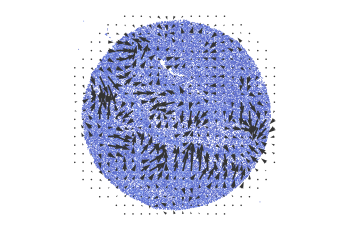

In [23]:
ct.pl.plot_cell_communication(adata, database_name='cellchat', plot_method='grid', filename='./figure/ccc_dir-all.pdf', scale=0.00005,
    interp_k=20, ndsize=0.75, grid_density=0.5, normalize_v=True, normalize_v_quantile=0.995)

In [27]:
for pathway in ranked_pathway:
    ct.tl.communication_direction(adata, database_name='cellchat', pathway_name=pathway)
    ct.pl.plot_cell_communication(adata, database_name='cellchat', pathway_name=pathway,
        plot_method='grid', filename='./figure/ccc_dir/ccc_dir-%s.pdf' % pathway, scale=0.00005,
        interp_k=20, ndsize=0.75, grid_density=0.5, normalize_v=True, normalize_v_quantile=0.995)
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## **Cluster-cluster communication network**

In [28]:
for pathway in ranked_pathway:
    ct.tl.cluster_communication(adata, database_name='cellchat', pathway_name=pathway, clustering='cluster')

In [29]:
ct.tl.cluster_communication(adata, database_name='cellchat', clustering='cluster')

In [30]:
ct.tl.cluster_position(adata, clustering='cluster')

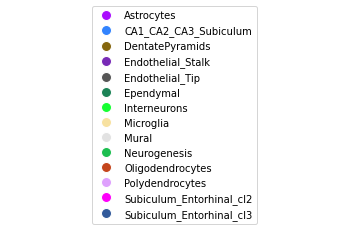

In [31]:
ct.pl.plot_cluster_communication_network(adata, uns_names=['commot_cluster-cluster-cellchat-total-total'], clustering='cluster', p_value_cutoff=0.05, 
    nx_node_cmap='Alphabet', nx_node_pos=None, nx_bg_pos=False, filename='ccc_cluster-all.pdf')

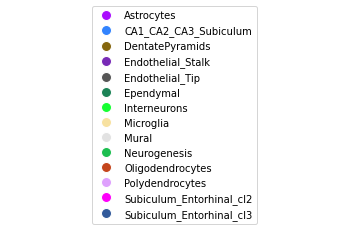

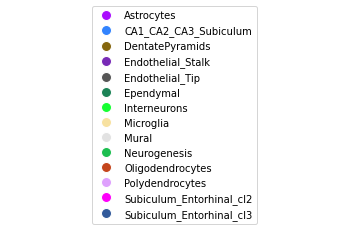

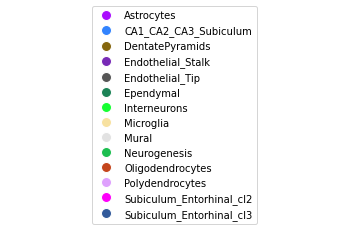

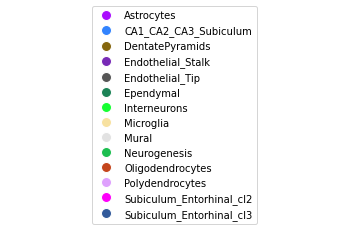

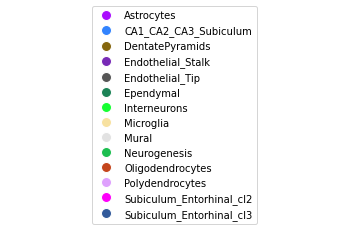

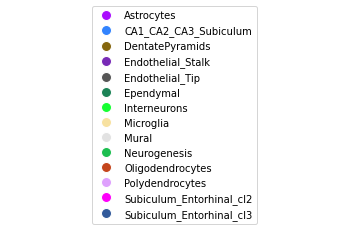

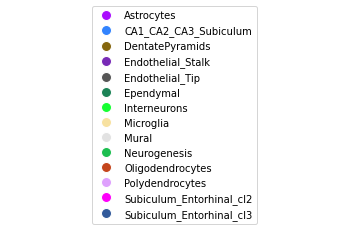

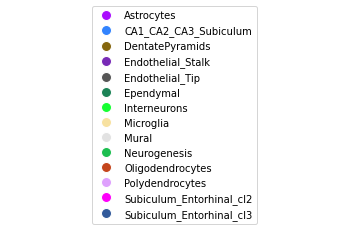

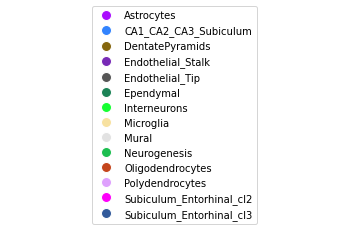

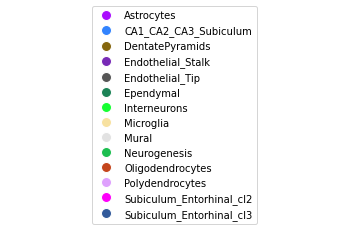

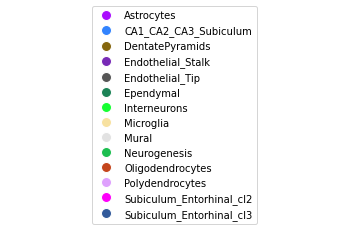

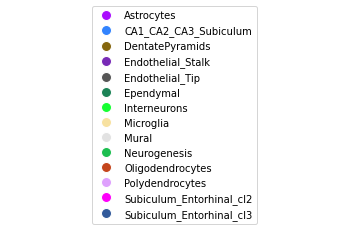

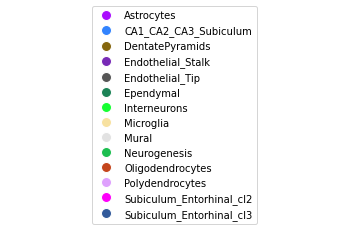

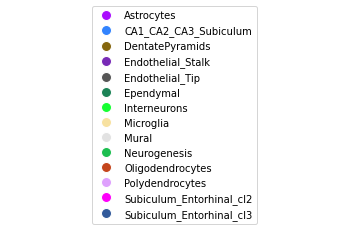

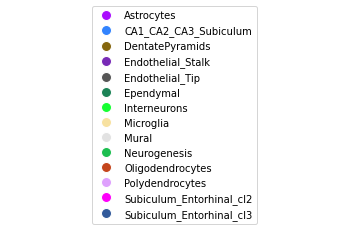

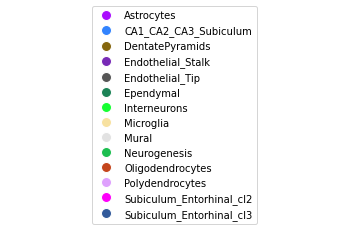

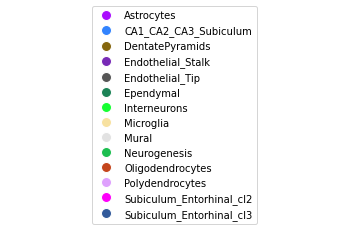

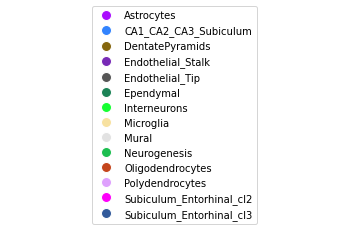

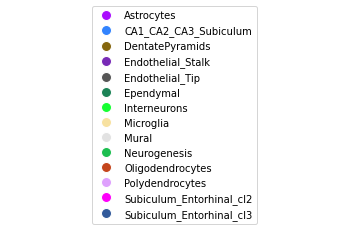

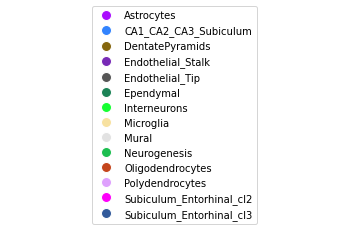

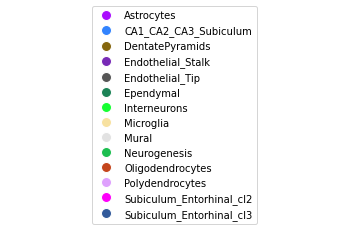

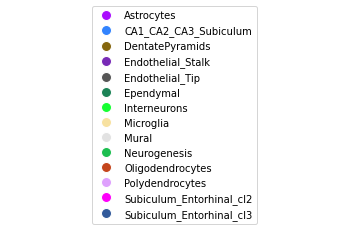

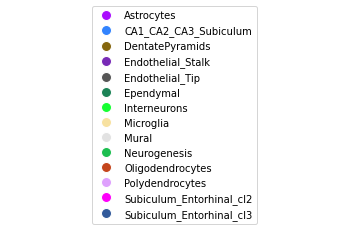

In [34]:
for pathway in ranked_pathway:
    ct.pl.plot_cluster_communication_network(adata, uns_names=['commot_cluster-cluster-cellchat-%s' % pathway], clustering='cluster', p_value_cutoff=0.05, 
        nx_node_cmap='Alphabet', nx_node_pos=None, nx_bg_pos=False, filename='ccc_cluster-%s.pdf' % pathway)

In [35]:
adata.write("./data/adata.h5ad")

In [36]:
import seaborn as sns
def plot_cluster_cluster_communication_dotplot(
    df_comm,
    df_p_value,
    sig_p = 0.05,
    vmin_quantile = 0.5,
    vmax_quantile = 0.9,
    sig_p_symbol = '$\circ$',
    unsig_p_symbol = 'o',
    vmin_size = 25,
    vmax_size = 150,
    sig_color = 'darkblue',
    unsig_color = 'lightblue'
):
    col_names = df_comm.columns.values
    row_names = df_comm.index
    m,n = df_comm.shape
    X_comm = df_comm.values
    p_comm = df_p_value.values
    vmax = np.quantile(X_comm.flatten(), vmax_quantile)
    vmin = np.quantile(X_comm.flatten(), vmin_quantile)
    if vmin == 0:
        vmin = 1e-20
    X_comm_vec = []
    p_vec = []
    x_vec = []
    y_vec = []
    p_vec = []
    for i in range(m):
        for j in range(n):
            X_comm_vec.append(X_comm[i,j])_filteredcellchat_dis1000
            x_vec.append(row_names[i])
            y_vec.append(col_names[j])
            p_vec.append(p_comm[i,j])
    X_comm_vec = np.array(X_comm_vec)
    x_vec = np.array(x_vec, str)
    y_vec = np.array(y_vec, str)
    p_vec = np.array(p_vec)
    idx_plot = np.where(X_comm_vec >= vmin)[0]
    s_vec = ( X_comm_vec - vmin ) / ( vmax - vmin ) * (vmax_size - vmin_size) + vmin_size
    s_vec = X_comm_vec
    
    s_plot = s_vec[idx_plot]
    x_vec = x_vec[idx_plot]
    y_vec = y_vec[idx_plot]
    s_vec = s_vec[idx_plot]
    p_vec = p_vec[idx_plot]
    idx_sig = np.where(p_vec <= sig_p)[0]
    idx_unsig = np.where(p_vec > sig_p)[0]
    data_plot_sig = []
    for i in range(len(idx_sig)):
        ii = idx_sig[i]
        data_plot_sig.append([x_vec[ii], y_vec[ii], s_vec[ii]])
    data_plot_unsig = []
    for i in range(len(idx_unsig)):
        ii = idx_unsig[i]
        data_plot_unsig.append([x_vec[ii], y_vec[ii], s_vec[ii]])
    df_sig = pd.DataFrame(data = data_plot_sig, columns=['x','y','size_col'])
    df_unsig = pd.DataFrame(data = data_plot_unsig, columns=['x','y','size_col'])
    df_plot = pd.concat([df_sig, df_unsig])
    fc = ['white' for i in range(df_sig.shape[0])] + [unsig_color for i in range(df_unsig.shape[0])]
    ec = [sig_color for i in range(df_sig.shape[0])] + [unsig_color for i in range(df_unsig.shape[0])]
    
    sns.set_theme(style="whitegrid", font_scale=1)
    g = sns.relplot(data = df_plot, x='x', y='y', size='size_col', sizes=(vmin_size, vmax_size), marker='o', fc=fc, ec=ec, linewidth=2)
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.1)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")    

In [ ]:
for pathway in ranked_pathway:
    df_comm = adata.uns['commot_cluster-cluster-cellchat-%s' % pathway]['communication_matrix']
    df_pvalue = adata.uns['commot_cluster-cluster-cellchat-%s' % pathway]['communication_pvalue']
    plot_cluster_cluster_communication_dotplot(df_comm, df_pvalue)
    plt.savefig("./figure/ccc_cluster/ccc_dotplot-%s.pdf" % pathway, bbox_inches = 'tight')
    plt.clf()

## **Cluster-cluster communication network (spatial permutation)**

In [2]:
adata = sc.read_h5ad("./data/adata.h5ad")
adata_spatial_permutation_allcells = sq.datasets.slideseqv2()
adata_spatial_permutation_withincluster = sq.datasets.slideseqv2()

In [3]:
%%timeit -n1 -r1
ct.tl.cluster_communication_spatial_permutation(adata_spatial_permutation_withincluster, database_name='cellchat', clustering='cluster',
    n_permutations=100, dis_thr=200, heteromeric=True, df_ligrec = adata.uns['commot-cellchat-info']['df_ligrec'], cot_nitermax=100,
    perm_type='within_cluster')

(55, 3)
(55, 3)
Permutation:  0
Permutation:  1
Permutation:  2
Permutation:  3
Permutation:  4
Permutation:  5
Permutation:  6
Permutation:  7
Permutation:  8
Permutation:  9
Permutation:  10
Permutation:  11
Permutation:  12
Permutation:  13
Permutation:  14
Permutation:  15
Permutation:  16
Permutation:  17
Permutation:  18
Permutation:  19
Permutation:  20
Permutation:  21
Permutation:  22
Permutation:  23
Permutation:  24
Permutation:  25
Permutation:  26
Permutation:  27
Permutation:  28
Permutation:  29
Permutation:  30
Permutation:  31
Permutation:  32
Permutation:  33
Permutation:  34
Permutation:  35
Permutation:  36
Permutation:  37
Permutation:  38
Permutation:  39
Permutation:  40
Permutation:  41
Permutation:  42
Permutation:  43
Permutation:  44
Permutation:  45
Permutation:  46
Permutation:  47
Permutation:  48
Permutation:  49
Permutation:  50
Permutation:  51
Permutation:  52
Permutation:  53
Permutation:  54
Permutation:  55
Permutation:  56
Permutation:  57
Permutat

In [4]:
%%timeit -n1 -r1
ct.tl.cluster_communication_spatial_permutation(adata_spatial_permutation_allcells, database_name='cellchat', clustering='cluster',
    n_permutations=100, dis_thr=200, heteromeric=True, df_ligrec = adata.uns['commot-cellchat-info']['df_ligrec'], cot_nitermax=100,
    perm_type='all_cell')

(55, 3)
(55, 3)
Permutation:  0
Permutation:  1
Permutation:  2
Permutation:  3
Permutation:  4
Permutation:  5
Permutation:  6
Permutation:  7
Permutation:  8
Permutation:  9
Permutation:  10
Permutation:  11
Permutation:  12
Permutation:  13
Permutation:  14
Permutation:  15
Permutation:  16
Permutation:  17
Permutation:  18
Permutation:  19
Permutation:  20
Permutation:  21
Permutation:  22
Permutation:  23
Permutation:  24
Permutation:  25
Permutation:  26
Permutation:  27
Permutation:  28
Permutation:  29
Permutation:  30
Permutation:  31
Permutation:  32
Permutation:  33
Permutation:  34
Permutation:  35
Permutation:  36
Permutation:  37
Permutation:  38
Permutation:  39
Permutation:  40
Permutation:  41
Permutation:  42
Permutation:  43
Permutation:  44
Permutation:  45
Permutation:  46
Permutation:  47
Permutation:  48
Permutation:  49
Permutation:  50
Permutation:  51
Permutation:  52
Permutation:  53
Permutation:  54
Permutation:  55
Permutation:  56
Permutation:  57
Permutat

In [5]:
adata_spatial_permutation_allcells.write("./data/adata_spatial_permutation_allcells.h5ad")
adata_spatial_permutation_withincluster.write("./data/adata_spatial_permutation_withincluster.h5ad")